In [1]:
import mdtraj as md
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gro = md.load('frame0_nw.gro')

In [3]:
traj = md.load('plpro_yrl_100_whole_wrap.trr', top=gro.top)

In [4]:
lig = gro.top.select('resname == yrl')
# 89 * 20
lig_idx = np.arange(0,1780,20)

In [5]:
traj.superpose(gro, atom_indices=gro.top.select('backbone'))

<mdtraj.Trajectory with 30002 frames, 6998 atoms, 673 residues, and unitcells at 0x7f306f6e5400>

In [6]:
com_list = [0] * 89

for i in range(len(lig_idx)):
    small_traj = traj.atom_slice(lig[lig_idx[i]:lig_idx[i]+20])
    com_list[i] = md.compute_center_of_mass(small_traj)

In [7]:
import sklearn
from sklearn.cluster import DBSCAN

In [8]:
com_cat = np.concatenate(com_list)

In [13]:
cl = DBSCAN(eps=0.15, min_samples=6500).fit(com_cat)

In [14]:
len(set(cl.labels_))

7

In [11]:
def write_com_to_gro(com, file_name):
    ''' write center of mass point to gro file to open in VMD, chimera, or similiar'''
    with open(file_name, 'w') as f:
        f.write('Protein in water\n')
        f.write(' 1\n')
        f.write(f'    1GLU      N    1   {np.round(com[0], 3)}   {np.round(com[1], 3)}   {np.round(com[2], 3)}\n')
        f.write('  11.27360  11.27360  11.27360\n')

In [15]:
cluster_list = []
avg_list = []

for i in set(cl.labels_):
    if i == -1:
        continue
    cluster_list.append(com_cat[cl.labels_ == i])
    print(i, cluster_list[i].shape[0])
    avg_list.append(cluster_list[i].mean(axis=0))

0 10171
1 11288
2 20168
3 6503
4 16673
5 28942


In [16]:
for i in range(6):
    write_com_to_gro(avg_list[i], f'cluster/7ofu_50mm_cluster{i}.gro')

In [17]:
crystal = md.load('../../true_7ofs.gro')

In [22]:
cry_idx = crystal.top.select('resname == yrl')
lig_rmsds = [0] * 89

In [20]:
def manual_rmsd(a,b):
    result = np.ndarray((a.shape[0],1), dtype='float32')
    N = b.shape[1]
    for i in range(a.shape[0]):
        result[i] = np.sqrt(np.sum((a[i] - b[0]) ** 2) / N)
    return result

def ex_rmsd(traj, ref, ref_frame=0, atom_indices_traj=None, atom_indices_ref=None, alignment_indices=None):
    'align to protein then take rmsd of ligand'
    traj.superpose(ref, frame=ref_frame, atom_indices=alignment_indices, parallel=True)
    small_traj = traj.atom_slice(atom_indices_traj)
    small_ref = ref.atom_slice(atom_indices_ref)
    f = manual_rmsd(small_traj.xyz, small_ref.xyz)
    return f

In [23]:
for i in range(len(lig_idx)):
    lig_rmsds[i] = ex_rmsd(traj, crystal, atom_indices_traj=lig[lig_idx[i]:lig_idx[i]+20], atom_indices_ref=cry_idx, alignment_indices=gro.top.select('backbone'))

In [24]:
time = np.arange(0, 300.02, 0.01)

In [25]:
under_5_list = [0] * 89
for i in range(len(lig_rmsds)):
    under_5_list[i] = (lig_rmsds[i] < 0.5).sum()

In [26]:
for i in range(len(under_5_list)):
    print(i, under_5_list[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 2192
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0


Text(0, 0.5, 'Ligand RMSD (nm)')

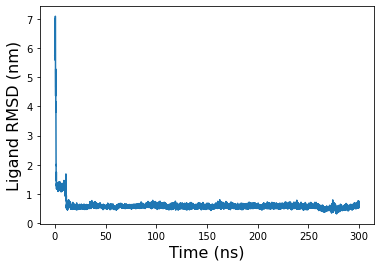

In [27]:
plt.plot(time, lig_rmsds[78])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

In [30]:
np.save('lowest_lig_rmsd.npy', lig_rmsds[78])

In [31]:
lig_rmsds[78].min()

0.3157896

In [29]:
lig_rmsds[78]

array([[5.743872  ],
       [5.7438054 ],
       [5.6937537 ],
       ...,
       [0.5406036 ],
       [0.5675859 ],
       [0.63930875]], dtype=float32)

In [7]:
# contact analysis

In [11]:
sites = 6
site_list = [md.load(f'cluster/7ofu_50mm_cluster{i}.gro') for i in range(sites)]

In [12]:
def calc_eu_dist(a,b):
    '''calculate the euclidean distance between two cartesian coordinate points'''
    dist = np.sqrt(np.sum((a - b) ** 2))
    return dist

In [13]:
def slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=20):
    '''takes trajectoy and retures seperate trajectories where ligands are in spots'''
    out_list3 = [0] * sites

    for i in range(sites):
        counter = 0
        for j in range(len(com_list)):
            #for k in range(traj.n_frames):
            d = [calc_eu_dist(l, site_list[i].xyz[0][0]) for l in com_list[j]]
            b = np.array(d)
            idx = np.where(b < 0.15)[0]
            if counter == 0:
                temp = traj[idx]
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = temp2
                counter = 1
            else:
                temp = traj[idx]                      
                temp2 = temp.atom_slice(np.concatenate((gro.top.select('protein'), lig[lig_idx[j]:lig_idx[j]+lig_atoms])))
                out_list3[i] = out_list3[i].join(temp2)
                
    return out_list3

In [14]:
out_list = slice_spots(traj, sites, com_list, site_list, gro, lig, lig_idx, lig_atoms=20)

In [15]:
out_list[0].save('sitetraj_cl0_A_s7.xtc')

In [16]:
out_list[1].save('sitetraj_cl1_B_s4.xtc')

In [17]:
out_list[2].save('sitetraj_cl2_C_s12.xtc')

In [18]:
out_list[3].save('sitetraj_cl3_D_s1.xtc')

In [19]:
out_list[4].save('sitetraj_cl4_E_s5.xtc')

In [20]:
out_list[5].save('sitetraj_cl5_F_s11.xtc')

In [24]:
start = out_list[0][0]

In [25]:
new_lig = start.top.select('resname == yrl and not name H')

In [26]:
res = np.zeros((315,2))
for i in range(315):
    res[i,0] = i
for i in range(315):
    res[i,1] = 315

In [27]:
def average_contacts(gro, traj_name, threshold):
    feat = coor.featurizer(gro)
    feat.add_residue_mindist(residue_pairs=res, threshold=threshold)
    min_dis = coor.load(traj_name, features=feat)
    mean = np.mean(min_dis.sum(axis=1))
    return mean

In [28]:
average_contacts(start, 'sitetraj_cl0_A_s7.xtc', 0.35)

1.2263739

In [29]:
average_contacts(start, 'sitetraj_cl0_A_s7.xtc', 0.4)

3.5407095

In [30]:
average_contacts(start, 'sitetraj_cl1_B_s4.xtc', 0.35)

2.414498

In [31]:
average_contacts(start, 'sitetraj_cl1_B_s4.xtc', 0.4)

6.0092936

In [32]:
average_contacts(start, 'sitetraj_cl2_C_s12.xtc', 0.35)

2.9207678

In [33]:
average_contacts(start, 'sitetraj_cl2_C_s12.xtc', 0.4)

5.8526115

In [34]:
average_contacts(start, 'sitetraj_cl3_D_s1.xtc', 0.35)

3.5418994

In [35]:
average_contacts(start, 'sitetraj_cl3_D_s1.xtc', 0.4)

7.3100557

In [36]:
average_contacts(start, 'sitetraj_cl4_E_s5.xtc', 0.35)

3.8864827

In [37]:
average_contacts(start, 'sitetraj_cl4_E_s5.xtc', 0.4)

7.551172

In [38]:
average_contacts(start, 'sitetraj_cl5_F_s11.xtc', 0.35)

4.496356

In [39]:
average_contacts(start, 'sitetraj_cl5_F_s11.xtc', 0.4)

8.743894